In [1]:
include("src/SimFunctions.jl")
include("src/PlotFunctions.jl")
using Profile

In [2]:
using BenchmarkTools
q = @SVector [0.,0,0]
p = @SVector [1.,2.,3.]

3-element SVector{3, Float64} with indices SOneTo(3):
 1.0
 2.0
 3.0

In [3]:
G = @SMatrix [0. 0. 0.;
	 0. 0. 0.;
	 1. 0. 0.]
k_density_spinon_dispersion = 30
k_density_specweight=10


path_spinons = generate_path(geom.high_symmetry_points, 
	    split("\\Gamma X W K \\Gamma L U W"), 
		points_per_unit=k_density_spinon_dispersion, K_units=2π/8)
	
path = generate_path(geom.high_symmetry_points, 
	    split("\\Gamma X W K \\Gamma L U W"),
		points_per_unit=k_density_specweight, K_units=4π/8)


data_dir = "tmp"

"tmp"

In [4]:
# α should be a 3 x 4 matrix such that 
# A_μ (I_i e_i ) = I_i α_iμ
function construct_landau_gauge(lattice::geom.PyroPrimitive, α)
    A_tet_sites = geom.A_sites(lattice)
    
    A = zeros(Float64, length(A_tet_sites),4)
    for (J, tA) in enumerate(A_tet_sites)
        I, _ = geom.tetra_IDX(lattice, tA) # The three-tuple that does the thing
        A[J,:] = I' * α
    end
    # consistency
    println(exp.(1im* lat.L'*α))
    # @assert all(abs.(exp.(1im* lat.L'*α) .- 1.) .< 1e-10)
    return A
end

construct_landau_gauge (generic function with 1 method)

In [5]:
# 0 flux
sim = SimulationParameters("TEST-0flux", 
    lattice=geom.PyroPrimitive(1,1,1),
    A=[0 0 0 0],
    Jpm = -0.04,
    B=[0,0,0]
    )
λ = calc_lambda(sim)

0.1351605109892234

In [6]:
lat = geom.PyroPrimitive(2,2,1)
calc_fluxes(lat, construct_landau_gauge(lat, [π 0 π 0; π 0 0 0; 0 0 0 0]))

ComplexF64[1.0 - 4.898587196589413e-16im 1.0 - 0.0im 1.0 - 2.4492935982947064e-16im 1.0 - 0.0im]


4×4 Matrix{Float64}:
  3.14159   3.14159  -3.14159  -3.14159
  3.14159  -3.14159  -3.14159   3.14159
 -3.14159   3.14159   3.14159  -3.14159
 -3.14159  -3.14159   3.14159   3.14159

In [7]:
# pipi00 flux
sim = SimulationParameters("TEST-pipi00", 
    lattice=geom.PyroPrimitive(1,2,1),
    A=[π 0 0 0; 0 π 0 0],
    Jpm = -0.04,
    B=[0.02,0.02,0]
    )
λ = calc_lambda(sim)

0.13366729006077077

In [8]:
# pi-flux
lat = geom.PyroPrimitive(2,2,1)
A_piflux = construct_landau_gauge(lat, [0 0 0 π; 0 π 0 π; 0 0 0 0])
calc_fluxes(lat, A_piflux)


ComplexF64[1.0 - 0.0im 1.0 - 2.4492935982947064e-16im 1.0 - 0.0im 1.0 - 4.898587196589413e-16im]


4×4 Matrix{Float64}:
 -3.14159  -3.14159   3.14159   3.14159
 -3.14159   3.14159   3.14159  -3.14159
  3.14159  -3.14159  -3.14159   3.14159
  3.14159   3.14159  -3.14159  -3.14159

Plotting spinon dispersions...


Spinon Dispersion: 100%|████████████████████████████████| Time: 0:00:00Spinon Dispersion:   1%|▍                               |  ETA: 0:00:12


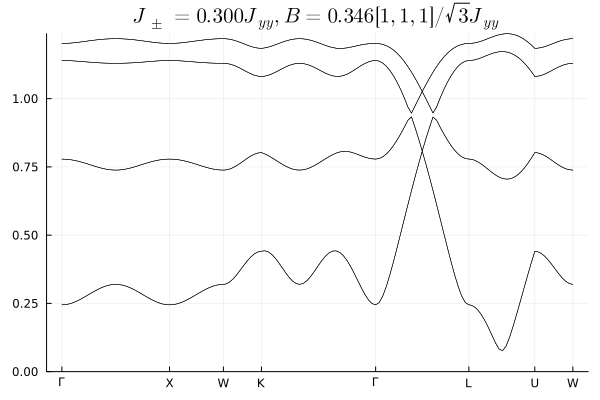

In [9]:
println("Plotting spinon dispersions...")


sim = SimulationParameters("TEST-piflux", 
    lattice=lat,
    A=A_piflux,
    Jpm = 0.3,
    B=[0.2,0.2,0.2]
    )
λ = calc_lambda(sim)
# compute spinons
d = calc_spinons_along_path(data_dir, sim=sim, λ=λ, path=path_spinons)
	
p = plot_spinons(load(d))


In [6]:

	# autorange this based on the spinon dispersion
max_E = 3.2
Egrid = collect(range(0,max_E,150)); # TODO consider updating this based on broadening_dE
datafiles = []

Any[]

In [26]:
@benchmark SpinonStructure.Lorentzian(0.5, 0.01)


BenchmarkTools.Trial: 10000 samples with 1000 evaluations.
 Range (min … max):  0.875 ns … 28.084 ns  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     0.958 ns              ┊ GC (median):    0.00%
 Time  (mean ± σ):   0.968 ns ±  0.508 ns  ┊ GC (mean ± σ):  0.00% ± 0.00%

                              █▁                              
  ▂▁▁▁▁▁▁▁▁▁▁▁▁▁▆▁▁▁▁▁▁▁▁▁▁▁▁▁██▁▁▁▁▁▁▁▁▁▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▂ ▂
  0.875 ns       Histogram: frequency by time        1.04 ns <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [6]:
@benchmark corr_at(q, p, sim, λ)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  57.000 μs …  3.852 ms  ┊ GC (min … max): 0.00% … 97.50%
 Time  (median):     57.958 μs              ┊ GC (median):    0.00%
 Time  (mean ± σ):   61.598 μs ± 83.363 μs  ┊ GC (mean ± σ):  5.38% ±  4.10%

       ▃▂██▆                                                   
  ▂▂▃▄████████▅▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▂▂▂▂ ▃
  57 μs           Histogram: frequency by time        63.7 μs <

 Memory estimate: 84.94 KiB, allocs estimate: 1842.

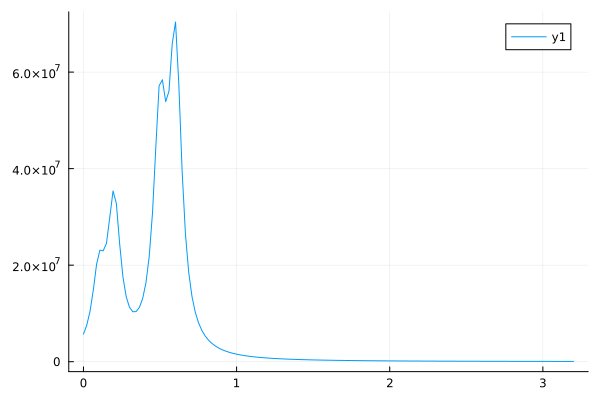

In [14]:
plot(Egrid, real(Sqω))

In [28]:

@benchmark spectral_weight(q, collect(range(0.,4.,50)), sim, λ, integration_settings["fast"])


LoadError: UndefVarError: `sim` not defined

In [13]:
@benchmark spectral_weight(q, collect(range(0.,4.,50)), sim, λ, integration_settings["slow"])


LoadError: MethodError: no method matching copyto!(::ComplexF64, ::Base.Broadcast.Broadcasted{Base.Broadcast.DefaultArrayStyle{0}, Tuple{}, typeof(+), Tuple{ComplexF64, ComplexF64}})

[0mClosest candidates are:
[0m  copyto!([91m::AbstractArray[39m, ::Base.Broadcast.Broadcasted{<:Base.Broadcast.AbstractArrayStyle{0}})
[0m[90m   @[39m [90mBase[39m [90m[4mbroadcast.jl:959[24m[39m
[0m  copyto!([91m::AbstractArray[39m, ::Base.Broadcast.Broadcasted)
[0m[90m   @[39m [90mBase[39m [90m[4mbroadcast.jl:956[24m[39m
[0m  copyto!([91m::AbstractArray[39m, ::Any)
[0m[90m   @[39m [90mBase[39m [90m[4mabstractarray.jl:940[24m[39m


In [14]:
Profile.clear()

@benchmark calc_spectral_weight_along_path(data_dir, 
	    sim=sim,
        λ=λ,
	    ip=integration_settings["very_fast"], 
	    Egrid=Egrid, path=path, g_tensor=G)
	    # f = data_dir*"/SQW"*sim_identifier(sim)*".jld"



LoadError: TaskFailedException

[91m    nested task error: [39mMethodError: no method matching copyto!(::ComplexF64, ::Base.Broadcast.Broadcasted{Base.Broadcast.DefaultArrayStyle{0}, Tuple{}, typeof(+), Tuple{ComplexF64, ComplexF64}})
    
    [0mClosest candidates are:
    [0m  copyto!([91m::AbstractArray[39m, ::Base.Broadcast.Broadcasted{<:Base.Broadcast.AbstractArrayStyle{0}})
    [0m[90m   @[39m [90mBase[39m [90m[4mbroadcast.jl:959[24m[39m
    [0m  copyto!([91m::AbstractArray[39m, ::Base.Broadcast.Broadcasted)
    [0m[90m   @[39m [90mBase[39m [90m[4mbroadcast.jl:956[24m[39m
    [0m  copyto!([91m::AbstractArray[39m, ::Any)
    [0m[90m   @[39m [90mBase[39m [90m[4mabstractarray.jl:940[24m[39m
    
    Stacktrace:
     [1] [0m[1mmacro expansion[22m
    [90m   @[39m [90m~/gh/spinon-calc/src/[39m[90m[4mSimFunctions.jl:181[24m[39m[90m [inlined][39m
     [2] [0m[1m(::var"#78#threadsfor_fun#12"{var"#78#threadsfor_fun#11#13"{SimulationParameters, Float64, IntegrationParameters, BZPath, SMatrix{3, 3, Float64, 9}, Sqω_set, Progress, Matrix{Float64}, Matrix{Float64}, Matrix{ComplexF64}, Matrix{ComplexF64}, UnitRange{Int64}}})[22m[0m[1m([22m[90mtid[39m::[0mInt64; [90monethread[39m::[0mBool[0m[1m)[22m
    [90m   @[39m [36mMain[39m [90m./[39m[90m[4mthreadingconstructs.jl:215[24m[39m
     [3] [0m[1m#78#threadsfor_fun[22m
    [90m   @[39m [90m./[39m[90m[4mthreadingconstructs.jl:182[24m[39m[90m [inlined][39m
     [4] [0m[1m(::Base.Threads.var"#1#2"{var"#78#threadsfor_fun#12"{var"#78#threadsfor_fun#11#13"{SimulationParameters, Float64, IntegrationParameters, BZPath, SMatrix{3, 3, Float64, 9}, Sqω_set, Progress, Matrix{Float64}, Matrix{Float64}, Matrix{ComplexF64}, Matrix{ComplexF64}, UnitRange{Int64}}}, Int64})[22m[0m[1m([22m[0m[1m)[22m
    [90m   @[39m [90mBase.Threads[39m [90m./[39m[90m[4mthreadingconstructs.jl:154[24m[39m
    
    [91mcaused by: [39mMethodError: no method matching copyto!(::ComplexF64, ::Base.Broadcast.Broadcasted{Base.Broadcast.DefaultArrayStyle{0}, Tuple{}, typeof(+), Tuple{ComplexF64, ComplexF64}})
    
    [0mClosest candidates are:
    [0m  copyto!([91m::AbstractArray[39m, ::Base.Broadcast.Broadcasted{<:Base.Broadcast.AbstractArrayStyle{0}})
    [0m[90m   @[39m [90mBase[39m [90m[4mbroadcast.jl:959[24m[39m
    [0m  copyto!([91m::AbstractArray[39m, ::Base.Broadcast.Broadcasted)
    [0m[90m   @[39m [90mBase[39m [90m[4mbroadcast.jl:956[24m[39m
    [0m  copyto!([91m::AbstractArray[39m, ::Any)
    [0m[90m   @[39m [90mBase[39m [90m[4mabstractarray.jl:940[24m[39m
    
    Stacktrace:
     [1] [0m[1mspectral_weight![22m[0m[1m([22m[90mintensity[39m::[0mSqω_set, [90mq[39m::[0mSVector[90m{3, Float64}[39m, [90msim[39m::[0mSimulationParameters, [90mλ[39m::[0mFloat64, [90mintegral_params[39m::[0mIntegrationParameters, [90mg_tensor[39m::[0mSMatrix[90m{3, 3, Float64, 9}[39m[0m[1m)[22m
    [90m   @[39m [35mMain.SpinonStructure[39m [90m~/gh/spinon-calc/src/[39m[90m[4mSpinonStructure.jl:563[24m[39m
     [2] [0m[1mmacro expansion[22m
    [90m   @[39m [90m~/gh/spinon-calc/src/[39m[90m[4mSimFunctions.jl:172[24m[39m[90m [inlined][39m
     [3] [0m[1m(::var"#78#threadsfor_fun#12"{var"#78#threadsfor_fun#11#13"{SimulationParameters, Float64, IntegrationParameters, BZPath, SMatrix{3, 3, Float64, 9}, Sqω_set, Progress, Matrix{Float64}, Matrix{Float64}, Matrix{ComplexF64}, Matrix{ComplexF64}, UnitRange{Int64}}})[22m[0m[1m([22m[90mtid[39m::[0mInt64; [90monethread[39m::[0mBool[0m[1m)[22m
    [90m   @[39m [36mMain[39m [90m./[39m[90m[4mthreadingconstructs.jl:215[24m[39m
     [4] [0m[1m#78#threadsfor_fun[22m
    [90m   @[39m [90m./[39m[90m[4mthreadingconstructs.jl:182[24m[39m[90m [inlined][39m
     [5] [0m[1m(::Base.Threads.var"#1#2"{var"#78#threadsfor_fun#12"{var"#78#threadsfor_fun#11#13"{SimulationParameters, Float64, IntegrationParameters, BZPath, SMatrix{3, 3, Float64, 9}, Sqω_set, Progress, Matrix{Float64}, Matrix{Float64}, Matrix{ComplexF64}, Matrix{ComplexF64}, UnitRange{Int64}}}, Int64})[22m[0m[1m([22m[0m[1m)[22m
    [90m   @[39m [90mBase.Threads[39m [90m./[39m[90m[4mthreadingconstructs.jl:154[24m[39m
    
    [91mcaused by: [39mMethodError: no method matching copyto!(::ComplexF64, ::Base.Broadcast.Broadcasted{Base.Broadcast.DefaultArrayStyle{0}, Tuple{}, typeof(+), Tuple{ComplexF64, ComplexF64}})
    
    [0mClosest candidates are:
    [0m  copyto!([91m::AbstractArray[39m, ::Base.Broadcast.Broadcasted{<:Base.Broadcast.AbstractArrayStyle{0}})
    [0m[90m   @[39m [90mBase[39m [90m[4mbroadcast.jl:959[24m[39m
    [0m  copyto!([91m::AbstractArray[39m, ::Base.Broadcast.Broadcasted)
    [0m[90m   @[39m [90mBase[39m [90m[4mbroadcast.jl:956[24m[39m
    [0m  copyto!([91m::AbstractArray[39m, ::Any)
    [0m[90m   @[39m [90mBase[39m [90m[4mabstractarray.jl:940[24m[39m
    
    Stacktrace:
     [1] [0m[1mmaterialize![22m
    [90m   @[39m [90m./[39m[90m[4mbroadcast.jl:914[24m[39m[90m [inlined][39m
     [2] [0m[1mmaterialize![22m
    [90m   @[39m [90m./[39m[90m[4mbroadcast.jl:911[24m[39m[90m [inlined][39m
     [3] [0m[1mbroadened_peaks![22m[0m[1m([22m[90mSqω[39m::[0mVector[90m{ComplexF64}[39m, [90mSnm[39m::[0mMatrix[90m{ComplexF64}[39m, [90mEnm[39m::[0mMatrix[90m{Float64}[39m, [90mEgrid[39m::[0mVector[90m{Float64}[39m, [90mdE[39m::[0mFloat64[0m[1m)[22m
    [90m   @[39m [35mMain.SpinonStructure[39m [90m~/gh/spinon-calc/src/[39m[90m[4mSpinonStructure.jl:448[24m[39m
     [4] [0m[1mspectral_weight![22m[0m[1m([22m[90mintensity[39m::[0mSqω_set, [90mq[39m::[0mSVector[90m{3, Float64}[39m, [90msim[39m::[0mSimulationParameters, [90mλ[39m::[0mFloat64, [90mintegral_params[39m::[0mIntegrationParameters, [90mg_tensor[39m::[0mSMatrix[90m{3, 3, Float64, 9}[39m[0m[1m)[22m
    [90m   @[39m [35mMain.SpinonStructure[39m [90m~/gh/spinon-calc/src/[39m[90m[4mSpinonStructure.jl:546[24m[39m
     [5] [0m[1mmacro expansion[22m
    [90m   @[39m [90m~/gh/spinon-calc/src/[39m[90m[4mSimFunctions.jl:172[24m[39m[90m [inlined][39m
     [6] [0m[1m(::var"#78#threadsfor_fun#12"{var"#78#threadsfor_fun#11#13"{SimulationParameters, Float64, IntegrationParameters, BZPath, SMatrix{3, 3, Float64, 9}, Sqω_set, Progress, Matrix{Float64}, Matrix{Float64}, Matrix{ComplexF64}, Matrix{ComplexF64}, UnitRange{Int64}}})[22m[0m[1m([22m[90mtid[39m::[0mInt64; [90monethread[39m::[0mBool[0m[1m)[22m
    [90m   @[39m [36mMain[39m [90m./[39m[90m[4mthreadingconstructs.jl:215[24m[39m
     [7] [0m[1m#78#threadsfor_fun[22m
    [90m   @[39m [90m./[39m[90m[4mthreadingconstructs.jl:182[24m[39m[90m [inlined][39m
     [8] [0m[1m(::Base.Threads.var"#1#2"{var"#78#threadsfor_fun#12"{var"#78#threadsfor_fun#11#13"{SimulationParameters, Float64, IntegrationParameters, BZPath, SMatrix{3, 3, Float64, 9}, Sqω_set, Progress, Matrix{Float64}, Matrix{Float64}, Matrix{ComplexF64}, Matrix{ComplexF64}, UnitRange{Int64}}}, Int64})[22m[0m[1m([22m[0m[1m)[22m
    [90m   @[39m [90mBase.Threads[39m [90m./[39m[90m[4mthreadingconstructs.jl:154[24m[39m

...and 3 more exceptions.


In [15]:
data = load(f)

LoadError: UndefVarError: `f` not defined

In [16]:
heatmap(real(data["intensity"]["Spm"])')

LoadError: UndefVarError: `data` not defined

In [17]:
heatmap(imag(data["intensity"]["Spm"])')

LoadError: UndefVarError: `data` not defined

In [18]:
heatmap(real(data["intensity"]["Spp"])')

LoadError: UndefVarError: `data` not defined

In [19]:
heatmap(imag(data["intensity"]["Spp"])')

LoadError: UndefVarError: `data` not defined

In [20]:


# Profile.clear()


@benchmark corr_at(q, p, sim, λ, SMatrix{3,3}([1. 0 0; 0 1 0; 0 0 1])) 


LoadError: MethodError: no method matching corr_at(::SVector{3, Float64}, ::Plots.Plot{Plots.GRBackend}, ::SimulationParameters, ::Float64, ::SMatrix{3, 3, Float64, 9})

[0mClosest candidates are:
[0m  corr_at(::SVector{3, Float64}, [91m::SVector{3, Float64}[39m, ::SimulationParameters, ::Float64, ::Union{Nothing, SMatrix{3, 3, Float64}})
[0m[90m   @[39m [35mMain.SpinonStructure[39m [90m~/gh/spinon-calc/src/[39m[90m[4mSpinonStructure.jl:356[24m[39m
[0m  corr_at(::SVector{3, Float64}, [91m::SVector{3, Float64}[39m, ::SimulationParameters, ::Float64)
[0m[90m   @[39m [35mMain.SpinonStructure[39m [90m~/gh/spinon-calc/src/[39m[90m[4mSpinonStructure.jl:356[24m[39m


In [21]:
@benchmark corr_at(q, p, sim, λ, nothing)

LoadError: MethodError: no method matching corr_at(::SVector{3, Float64}, ::Plots.Plot{Plots.GRBackend}, ::SimulationParameters, ::Float64, ::Nothing)

[0mClosest candidates are:
[0m  corr_at(::SVector{3, Float64}, [91m::SVector{3, Float64}[39m, ::SimulationParameters, ::Float64, ::Union{Nothing, SMatrix{3, 3, Float64}})
[0m[90m   @[39m [35mMain.SpinonStructure[39m [90m~/gh/spinon-calc/src/[39m[90m[4mSpinonStructure.jl:356[24m[39m
[0m  corr_at(::SVector{3, Float64}, [91m::SVector{3, Float64}[39m, ::SimulationParameters, ::Float64)
[0m[90m   @[39m [35mMain.SpinonStructure[39m [90m~/gh/spinon-calc/src/[39m[90m[4mSpinonStructure.jl:356[24m[39m


In [22]:
Profile.clear()
@profile [corr_at(q, p, sim, λ) for _ in 1:100]

Profile.print()

LoadError: MethodError: no method matching corr_at(::SVector{3, Float64}, ::Plots.Plot{Plots.GRBackend}, ::SimulationParameters, ::Float64)

[0mClosest candidates are:
[0m  corr_at(::SVector{3, Float64}, [91m::SVector{3, Float64}[39m, ::SimulationParameters, ::Float64)
[0m[90m   @[39m [35mMain.SpinonStructure[39m [90m~/gh/spinon-calc/src/[39m[90m[4mSpinonStructure.jl:356[24m[39m
[0m  corr_at(::SVector{3, Float64}, [91m::SVector{3, Float64}[39m, ::SimulationParameters, ::Float64, [91m::Union{Nothing, SMatrix{3, 3, Float64}}[39m)
[0m[90m   @[39m [35mMain.SpinonStructure[39m [90m~/gh/spinon-calc/src/[39m[90m[4mSpinonStructure.jl:356[24m[39m


In [23]:
using ProfileView

ProfileView.view()

Gtk.GtkWindowLeaf(name="", parent, width-request=-1, height-request=-1, visible=TRUE, sensitive=TRUE, app-paintable=FALSE, can-focus=FALSE, has-focus=FALSE, is-focus=FALSE, focus-on-click=TRUE, can-default=FALSE, has-default=FALSE, receives-default=FALSE, composite-child=FALSE, style, events=0, no-show-all=FALSE, has-tooltip=FALSE, tooltip-markup=NULL, tooltip-text=NULL, window, opacity=1.000000, double-buffered, halign=GTK_ALIGN_FILL, valign=GTK_ALIGN_FILL, margin-left, margin-right, margin-start=0, margin-end=0, margin-top=0, margin-bottom=0, margin=0, hexpand=FALSE, vexpand=FALSE, hexpand-set=FALSE, vexpand-set=FALSE, expand=FALSE, scale-factor=2, border-width=0, resize-mode, child, type=GTK_WINDOW_TOPLEVEL, title="Profile", role=NULL, resizable=TRUE, modal=FALSE, window-position=GTK_WIN_POS_NONE, default-width=800, default-height=600, destroy-with-parent=FALSE, hide-titlebar-when-maximized=FALSE, icon, icon-name=NULL, screen, type-hint=GDK_WINDOW_TYPE_HINT_NORMAL, skip-taskbar-hint

In [24]:
@benchmark spinon_dispersion(q, sim, λ)


BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  161.791 μs …  4.900 ms  ┊ GC (min … max): 0.00% … 91.93%
 Time  (median):     176.541 μs              ┊ GC (median):    0.00%
 Time  (mean ± σ):   181.320 μs ± 96.188 μs  ┊ GC (mean ± σ):  1.61% ±  2.99%

              ▁▄▆▆█▇▇▆▄▂▂                                       
  ▁▁▁▁▂▂▂▂▃▃▅█████████████▇▆▅▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▃
  162 μs          Histogram: frequency by time          210 μs <

 Memory estimate: 52.31 KiB, allocs estimate: 1231.

In [25]:
@benchmark geom.tetra_idx(sim.lat, SVector{3}([0,0,0]))

BenchmarkTools.Trial: 10000 samples with 950 evaluations.
 Range (min … max):   98.553 ns …   3.686 μs  ┊ GC (min … max): 0.00% … 96.77%
 Time  (median):     102.719 ns               ┊ GC (median):    0.00%
 Time  (mean ± σ):   114.637 ns ± 185.729 ns  ┊ GC (mean ± σ):  9.25% ±  5.52%

   ▇█                                                            
  ▃██▅▂▁▂▂▂▁▁▃▇▆▄▃▃▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  98.6 ns          Histogram: frequency by time          131 ns <

 Memory estimate: 160 bytes, allocs estimate: 2.

In [26]:



data = load(f)
sim_x = SimulationParameters(data["physical_parameters"])
	
p = plot_spectral_weight(data,"Spm")
# savefig(p, figure_dir*"corr_S+-"*sim_identifier(sim_x)*".pdf")
	
	

LoadError: UndefVarError: `f` not defined

In [27]:

	    # p = plot_spectral_weight(data,"Spp")
	    # savefig(p, figure_dir*"corr_S++"*sim_identifier(sim_x)*".pdf")
	
	
p = plot_spectral_weight(data,"Smagnetic")
# savefig(p, figure_dir*"corr_Smagnetic"*sim_identifier(sim_x)*".pdf")

LoadError: UndefVarError: `data` not defined

In [24]:
data = load("output/int_fieldsweep?name=piflux-along?J_pm=0.300?B=[0.000,0.000,0.000].jld")

Dict{String, Any} with 3 entries:
  "integrated_intensity"   => Dict{String, Any}("Spp"=>ComplexF64[0.0+0.0im 0.0…
  "integration_parameters" => Dict{String, Any}("broadening_dE"=>0.05, "n_K_sam…
  "physical_parameters"    => Dict{String, Any}("emergent_fluxes"=>[-3.14159 -3…

In [25]:
intens = data["integrated_intensity"]

Dict{String, Any} with 5 entries:
  "Spp"                      => ComplexF64[0.0+0.0im 0.0+0.0im … 0.0+0.0im 0.0+…
  "W"                        => [0.0, 0.0214765, 0.042953, 0.0644295, 0.085906,…
  "magnetic_field_strengths" => [0.0, 0.0102041, 0.0204082, 0.0306122, 0.040816…
  "Spm"                      => ComplexF64[24.5812-7.03764e-19im 26.3798-5.4058…
  "Smagnetic"                => [5.11177 5.47249 … 0.814806 0.794484; 5.19012 5…

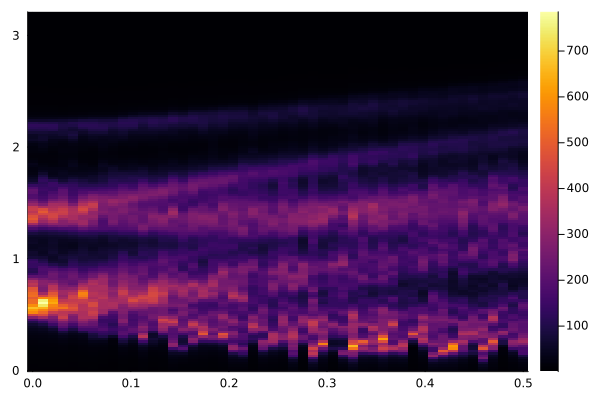

In [29]:
heatmap(intens["magnetic_field_strengths"], intens["W"],real(intens["Smagnetic"])')